<a href="https://colab.research.google.com/github/somilasthana/deeplearningtutorial/blob/master/UNET_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

In [3]:
import os

# Upload the API token.
def get_kaggle_credentials():
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
  try:
    with open(token_file,'r') as f:
      pass
  except IOError as no_file:
    try:
      from google.colab import files
    except ImportError:
      raise no_file
    
    uploaded = files.upload()
    
    if "kaggle.json" not in uploaded:
      raise ValueError("You need an API key! see: "
                       "https://github.com/Kaggle/kaggle-api#api-credentials")
    with open(token_file, "wb") as f:
      f.write(uploaded["kaggle.json"])
    os.chmod(token_file, 600)

get_kaggle_credentials()


Saving kaggle.json to kaggle.json


In [0]:
import kaggle

In [0]:
import os
import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [0]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import backend as K

In [0]:
competition_name = 'carvana-image-masking-challenge'

In [0]:
def load_data_from_zip(competition, file):
  with zipfile.ZipFile(os.path.join(competition, file), 'r') as zip_ref:
    unzipped_file = zip_ref.namelist()[0]
    zip_ref.extractall(competition)

In [0]:
def get_data(competition):
  kaggle.api.competition_download_files(competition, competition)
  load_data_from_zip(competition, 'train.zip')
  load_data_from_zip(competition, 'train_masks.zip')
  load_data_from_zip(competition, 'train_masks.csv.zip')

In [0]:
get_data(competition_name)

In [0]:
img_dir = os.path.join(competition_name, 'train')
label_dir = os.path.join(competition_name, 'train_masks')

In [12]:
df_train = pd.read_csv(os.path.join(competition_name, 'train_masks.csv'))
df_train.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [0]:
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [0]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
  x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [0]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(
    x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

In [0]:
len(x_train_filenames), len(x_val_filenames)
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

In [17]:
x_train_filenames[:3], y_train_filenames[:3]

(['carvana-image-masking-challenge/train/69915dab0755_16.jpg',
  'carvana-image-masking-challenge/train/695f39dfac16_04.jpg',
  'carvana-image-masking-challenge/train/2267f4aa0d2c_13.jpg'],
 ['carvana-image-masking-challenge/train_masks/69915dab0755_16_mask.gif',
  'carvana-image-masking-challenge/train_masks/695f39dfac16_04_mask.gif',
  'carvana-image-masking-challenge/train_masks/2267f4aa0d2c_13_mask.gif'])

In [0]:
display_num = 5
r_choices = np.random.choice(num_train_examples, display_num)

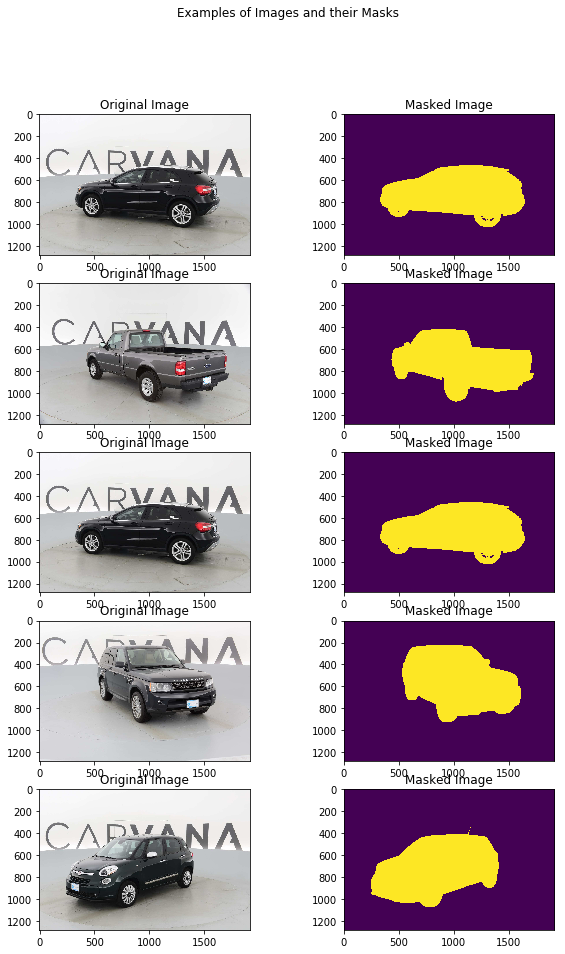

In [36]:
plt.figure(figsize=(10, 15))
for i in range(0, display_num*2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num, 2, i+1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_val = np.unique(example_labels)
  
  plt.subplot(display_num, 2, i+2)
  plt.imshow(example_labels)
  plt.title("Masked Image")
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

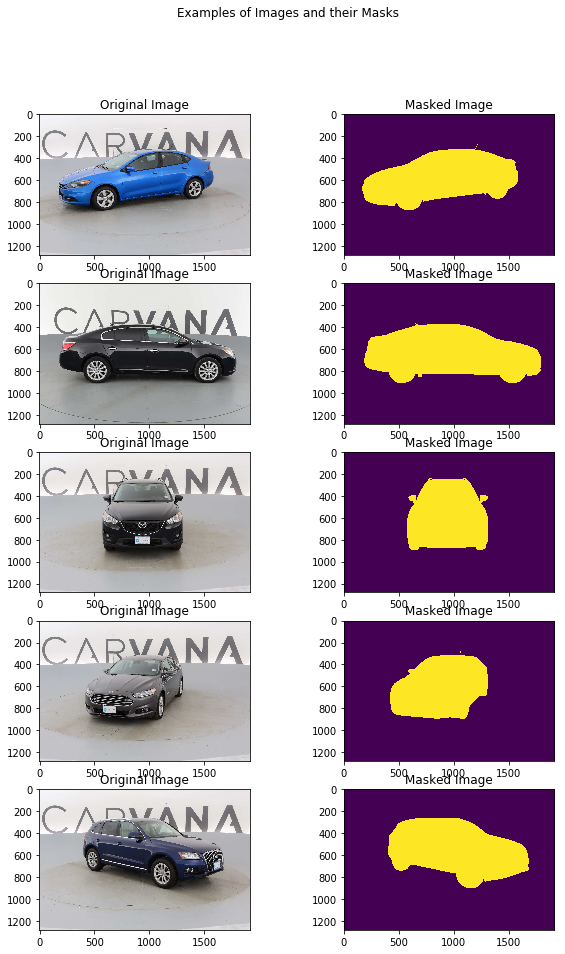

In [39]:
# Anyother run

In [0]:
img_shape = (64, 64, 3) # shd be multiple of 32
batch_size = 3
epochs = 5

Processing each pathname

In [0]:
def _process_pathnames(fname, label_path):
  img_str = tf.read_file(fname)
  
  img = tf.image.decode_jpeg(img_str, channels=3)
  
  label_img_str = tf.read_file(label_path)
  label_img = tf.image.decode_gif(label_img_str)[0]
  
  label_img = label_img[:, :, 0]
  label_img = tf.expand_dims(label_img, axis=-1)
  return img, label_img

In [0]:
img, label_img = _process_pathnames(x_train_filenames[0], y_train_filenames[0])

In [22]:
img.shape

TensorShape([Dimension(None), Dimension(None), Dimension(3)])

In [23]:
label_img.shape

TensorShape([Dimension(None), Dimension(None), Dimension(1)])

In [0]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
  if width_shift_range:
    width_shift_range = tf.random_uniform([], -width_shift_range*img_shape[1], width_shift_range*img_shape[1])
    
  if height_shift_range:
    height_shift_range = tf.random_uniform([], -height_shift_range*img_shape[0], height_shift_range*img_shape[0])
    
  output_img = tfcontrib.image.translate(output_img, [width_shift_range, height_shift_range])
  label_img  = tfcontrib.image.translate(label_img,  [width_shift_range, height_shift_range])
  
  return output_img, label_img

In [0]:
def flip_img(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_probability = tf.random.uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(
        tf.less(flip_probability, 0.5), 
        lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
        lambda: (tr_img, label_img)
    )
  return tr_img, label_img

In [0]:
def _augment(img,
             label_img,
             resize=None,
             scale=1,
             hue_delta = 0,
             horizontal_flip=False,
             width_shift_range=0,
             height_shift_range=0
            ):
  if resize is not None:
    label_img = tf.image.resize_images(label_img, resize)
    img = tf.image.resize_images(img, resize)
    
  if hue_delta:
    img = tf.image.random_hue(img, hue_delta)
    
  img, label_img = flip_img(horizontal_flip, img, label_img)
  
  img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
  
  label_img = tf.to_float(label_img)*scale
  img = tf.to_float(img) * scale 
  
  return img, label_img

In [0]:
def get_baseline_dataset(filenames,
                        labels,
                        preproc_fn,
                        threads=5,
                        batch_size=batch_size,
                        shuffle=True):
  num_x = len(filenames)
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  
  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
    
  dataset = dataset.repeat().batch(batch_size)
  
  return dataset

In [0]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}

tr_preprocessing_fn = functools.partial(_augment, ** tr_cfg)

In [0]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}

val_preprocessing_fn = functools.partial(_augment, ** val_cfg)

In [30]:
train_ds = get_baseline_dataset(x_train_filenames, y_train_filenames,
                                preproc_fn = tr_preprocessing_fn,
                                batch_size=batch_size
                               )

W0618 11:33:55.155095 139643812788096 deprecation.py:323] From <ipython-input-26-0094274c5deb>:21: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


In [0]:
val_ds = get_baseline_dataset(x_val_filenames, y_val_filenames,
                                preproc_fn = val_preprocessing_fn,
                                batch_size=batch_size
                               )

W0618 11:34:03.033963 139643812788096 deprecation.py:323] From <ipython-input-32-9b85f39be243>:8: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


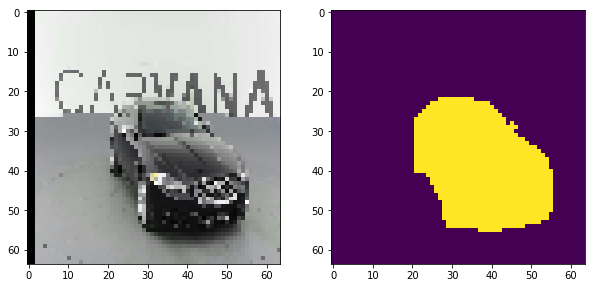

In [32]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)


data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

with tf.Session() as sess:
  batch_images, label = sess.run(next_element)
  
  plt.figure(figsize=(10, 10))
  img = batch_images[0]
  plt.subplot(1, 2, 1)
  plt.imshow(img)
  
  plt.subplot(1, 2, 2)
  plt.imshow(label[0, :, :, 0])
  
  plt.show()

Build UNet Model

In [0]:
"""
Unet model is built with an encoder and a decoder portion

Encoder 
Linear Stack of Conv, BatchNormalization, Relu, MaxPool. We keep track of 
the outputs of each block as we feed these high resolution feature maps with 
the decoder portion. 

Decoder
Consist of UpSampling2D, BatchNorm, Relu. we concatenate the feature map of
the same size on the decoder side.

Final Conv done on each pixel


"""

In [0]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3,3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3,3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  
  return encoder
  

In [0]:
def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPool2D((2,2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

In [0]:
def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2,2), strides=(2,2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3,3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3,3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  
  return decoder

In [0]:
inputs = layers.Input(shape=img_shape)
encoder0_pool, encoder0 = encoder_block(inputs, 32)
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)

center = conv_block(encoder4_pool, 1024)

decoder4 = decoder_block(center, encoder4, 512)
decoder3 = decoder_block(decoder4, encoder3, 256)
decoder2 = decoder_block(decoder3, encoder2, 128)
decoder1 = decoder_block(decoder2, encoder1, 64)
decoder0 = decoder_block(decoder1, encoder0, 32)

outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(decoder0)


In [0]:
model = models.Model(inputs=[inputs], outputs=[outputs])

In [0]:

def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [0]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [0]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [46]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

W0618 11:54:23.980410 139643812788096 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [0]:
save_model_path = '/tmp/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [49]:
history = model.fit(train_ds,
                    steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                    epochs=epochs,
                    validation_data= val_ds,
                    validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                    callbacks=[cp]
                   )

Epoch 1/5
1356/1357 [============================>.] - ETA: 0s - loss: 0.1399 - dice_loss: 0.0788
Epoch 00001: val_dice_loss improved from inf to 0.25280, saving model to /tmp/weights.hdf5
1357/1357 [==============================] - 260s 191ms/step - loss: 0.1398 - dice_loss: 0.0787 - val_loss: 0.7256 - val_dice_loss: 0.2528
Epoch 2/5
1355/1357 [============================>.] - ETA: 0s - loss: 0.0453 - dice_loss: 0.0236
Epoch 00002: val_dice_loss improved from 0.25280 to 0.02179, saving model to /tmp/weights.hdf5
1357/1357 [==============================] - 168s 124ms/step - loss: 0.0453 - dice_loss: 0.0236 - val_loss: 0.0424 - val_dice_loss: 0.0218
Epoch 3/5
1355/1357 [============================>.] - ETA: 0s - loss: 0.0374 - dice_loss: 0.0191
Epoch 00003: val_dice_loss improved from 0.02179 to 0.01902, saving model to /tmp/weights.hdf5
1357/1357 [==============================] - 170s 125ms/step - loss: 0.0374 - dice_loss: 0.0191 - val_loss: 0.0374 - val_dice_loss: 0.0190
Epoch 4/

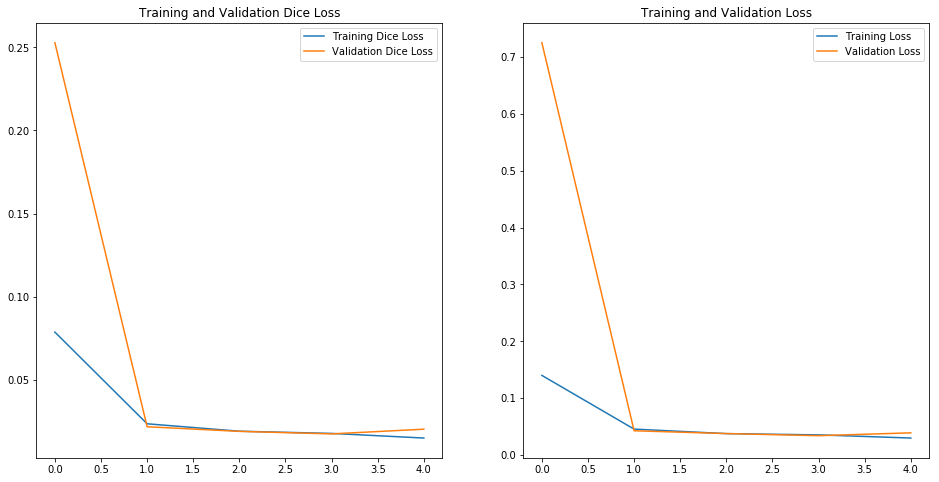

In [50]:

dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [0]:
#model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss,
#                                                           'dice_loss': dice_loss})

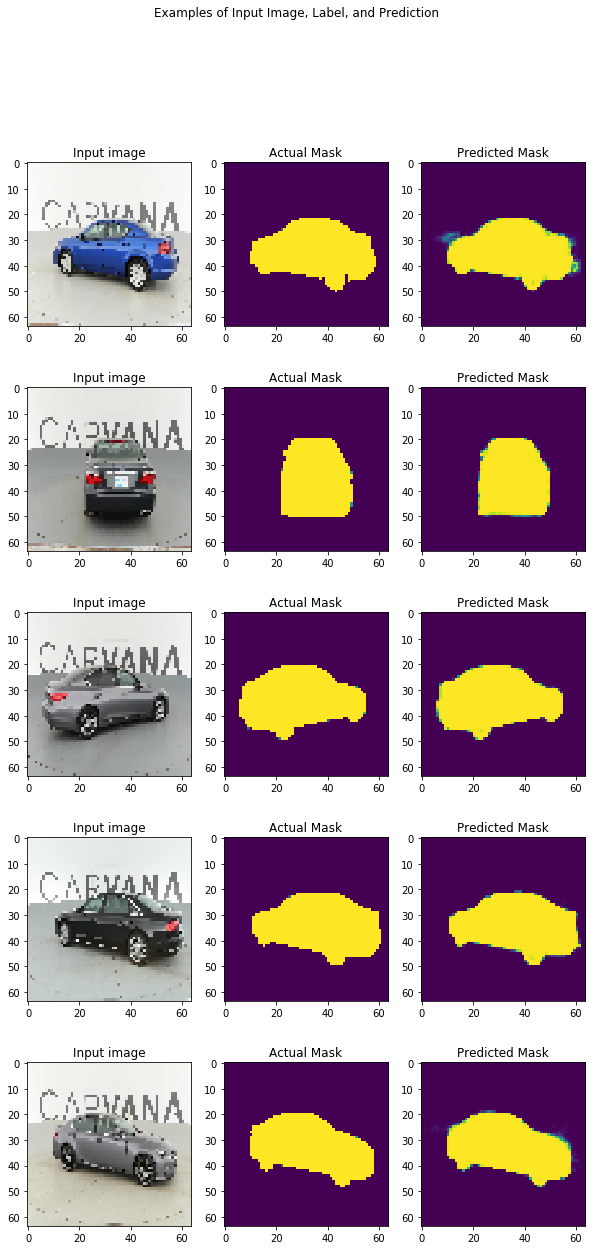

In [51]:
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

plt.figure(figsize=(10, 20))
for i in range(5):
  batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
  img = batch_of_imgs[0]
  predicted_label = model.predict(batch_of_imgs)[0]
  
  plt.subplot(5, 3, 3 * i + 1)
  plt.imshow(img)
  plt.title("Input image")
  
  plt.subplot(5, 3, 3 * i + 2)
  plt.imshow(label[0, :, :, 0])
  plt.title("Actual Mask")
  
  plt.subplot(5, 3, 3 * i + 3)
  plt.imshow(predicted_label[:, :, 0])
  plt.title("Predicted Mask")
  
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()